# Combination of SAM and depth anything metric version

In [2]:
# 0. install dependencies: PyTorch, Segment-anything, OpenCV, matplotlib, tqdm, pandas, Transformers(for Depth Anything)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib tqdm pandas
!pip install transformers accelerate safetensors

# 1. mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. file path configuration
import os
base_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/endovis2018_sub"
# endo_image_dir = f"{base_dir}/train/image"
val_image_dir = f"{base_dir}/val/image"
val_label_dir = f"{base_dir}/val/label"

output_mask_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/sam_masks"
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/image"
test_label_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/label"
test_mask_dir  = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/test/sam_mask"
fused_output_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/fused_depth"

for d in [output_mask_dir, test_image_dir, test_label_dir, test_mask_dir, fused_output_dir]:
    os.makedirs(d, exist_ok=True)

# 3. import libraries and SAM model
import torch
import cv2
import numpy as np, shutil, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/MR_Project/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# 4. Define SAM mask inference function
def generate_mask_with_sam(image_path, predictor, save_path=None, visualize=False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    masks, scores, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=True)
    best_mask = masks[np.argmax(scores)]
    if save_path:
        cv2.imwrite(save_path, (best_mask*255).astype(np.uint8))
    if visualize:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1); plt.imshow(image); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(best_mask,cmap='gray'); plt.title("Predicted Mask")
        plt.show(); plt.close('all')
    if device=="cuda": torch.cuda.empty_cache()
    return best_mask

# 5. Select validation samples
val_files = sorted([f for f in os.listdir(val_image_dir) if f.endswith(".bmp")])
if len(val_files)==0: raise ValueError(f"{val_image_dir} empty!")

np.random.seed(42)
num_samples = min(20,len(val_files))
sample_files = np.random.choice(val_files,num_samples,replace=False)
print("Selected validate files:",sample_files)

for fname in sample_files:
    shutil.copy(os.path.join(val_image_dir,fname),os.path.join(test_image_dir,fname))
    shutil.copy(os.path.join(val_label_dir,fname),os.path.join(test_label_dir,fname))
    generate_mask_with_sam(os.path.join(test_image_dir,fname),predictor,save_path=os.path.join(test_mask_dir,fname))

# 6. pixel-level accuracy calculation: SAM mask and the groundtruth
# Endovis 2018 dataset provides groundtruth
accuracy_list=[]
for fname in sample_files:
    label = cv2.imread(os.path.join(test_label_dir,fname),cv2.IMREAD_GRAYSCALE)
    mask  = cv2.imread(os.path.join(test_mask_dir,fname),cv2.IMREAD_GRAYSCALE)
    mask_bin = (mask>127).astype(np.uint8)
    label_bin = (label>127).astype(np.uint8)
    acc = (mask_bin==label_bin).sum()/label_bin.size
    accuracy_list.append({"filename":fname,"accuracy":acc})
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df["accuracy"] = (accuracy_df["accuracy"]*100).round(2)
print(f"Average pixel-level accuracy: {accuracy_df['accuracy'].mean():.2f}%")
display(accuracy_df)

Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kvjmio7p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kvjmio7p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Mounted at /content/drive
Using device: cuda
Selected validate files: ['seq_5_frame286.bmp' 'seq_1_frame298.bmp' 'seq_5_frame299.bmp'
 'seq_3_frame230.bmp' 'seq_2_frame254.bmp' 'seq_6_frame244.bmp'
 'seq_6_frame227.bmp' 'seq_2_frame274.bmp' 'seq_1_frame293.bmp'
 'seq_7_frame225.bmp' 'seq_1_frame234.bmp' 'seq_3_frame269.bmp'
 'seq_6_frame256.bmp' 'seq_2_frame234.bmp' 'seq_5_frame296.bmp'
 'seq_6_frame238.bmp' 'seq_7_frame270.bmp' 'seq_1_frame255.bmp'
 'seq_5_frame241.bmp' 'seq_6_frame258.bmp']
Average pixel-level accuracy: 68.96%


,filename,accuracy
0,seq_5_frame286.bmp,60.63
1,seq_1_frame298.bmp,95.36
2,seq_5_frame299.bmp,7.77
3,seq_3_frame230.bmp,51.25
4,seq_2_frame254.bmp,55.97
5,seq_6_frame244.bmp,100.00
6,seq_6_frame227.bmp,85.56
7,seq_2_frame274.bmp,71.44
8,seq_1_frame293.bmp,99.97
9,seq_7_frame225.bmp,56.54


In [3]:
# 7. DAM metric version. Load the pytorch model and inference manually
!apt-get install git-lfs
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git
%cd Depth-Anything-V2/metric_depth
!pip install -r requirements.txt

import sys
from transformers import pipeline
from PIL import Image
sys.path.append('.')
from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitb'             # or 'vits', 'vitb'
dataset = 'hypersim'         # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20               # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/MR_Project/depth_anything_v2_metric_hypersim_vitb.pth', map_location='cpu'))
model.eval()

def infer_depth_image(model, image: np.ndarray):
    """input RGB images, output depth map"""
    with torch.no_grad():
        depth = model.infer_image(image)
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    return depth_uint8

# 8. Define (optimized) mask fusion function for following depth estimation
def generate_depth_with_mask_optimized(image_path, mask_path,
                                       base_strength_org=0.5,
                                       base_strength_tool=0.8,
                                       blur_ksize=7,
                                       depth_model=None):

    img = np.array(Image.open(image_path).convert("RGB")).astype(np.float32)
    mask = np.array(Image.open(mask_path).convert("L"))
    mask_bin = (mask > 127).astype(np.float32)
    mask_smooth = cv2.GaussianBlur(mask_bin, (blur_ksize, blur_ksize), 0)

    red_ch = img[..., 0]
    tissue_mask = (mask_smooth > 0) & (red_ch > 100)
    tool_mask   = (mask_smooth > 0) & (red_ch <= 100)

    out = img.copy()
    out[tissue_mask, 1] = out[tissue_mask, 1]*(1-base_strength_org)+255*base_strength_org
    out[tissue_mask, 2] = out[tissue_mask, 2]*(1-base_strength_org)+255*base_strength_org
    out[tool_mask, 2] = out[tool_mask, 2]*(1-base_strength_tool)+255*base_strength_tool
    out[tool_mask, 0] = out[tool_mask, 0]*(1-0.3*base_strength_tool)
    mod_img = np.clip(out, 0, 255).astype(np.uint8)

    if depth_model is not None:
        depth_uint8 = infer_depth_image(depth_model, mod_img)
    else:
        depth_uint8 = None

    return mod_img, depth_uint8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 142 (delta 31), reused 24 (delta 24), pack-reused 82 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/Depth-Anything-V2/metric_depth
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:

'depth_pipe = pipeline(\n    task="depth-estimation",\n    model="depth-anything/Depth-Anything-V2-Small-hf",\n    device=0 if torch.cuda.is_available() else -1\n)\n\n# 8. Define (optimized) mask fusion function for following depth estimation\ndef generate_depth_with_mask_optimized(image_path, mask_path,\n                                       base_strength_org=0.5,   # strength factor for tissue, set as 0.5\n                                       base_strength_tool=0.8,  # strength factor for tool, set as 0.8\n                                       blur_ksize=7,            # Kernel size of Gaussian blur, for noise suppression, odd number\n                                       depth_pipe=None):\n    img = np.array(Image.open(image_path).convert("RGB")).astype(np.float32)\n    mask = np.array(Image.open(mask_path).convert("L"))\n    mask_bin = (mask>127).astype(np.float32)\n    mask_smooth = cv2.GaussianBlur(mask_bin,(blur_ksize,blur_ksize),0) # mask_smooth: smooth version of SAM Mask,

Generating optimized depth: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


,file,mode,mean_depth,std_depth
0,seq_5_frame286.bmp,original,95.493336,67.274845
1,seq_5_frame286.bmp,optimized,97.958076,77.328984
2,seq_1_frame298.bmp,original,164.448036,68.037086
3,seq_1_frame298.bmp,optimized,140.678341,64.126380
4,seq_5_frame299.bmp,original,116.873718,55.444806


total 20 comparisons.
seq_1_frame234_compare.png


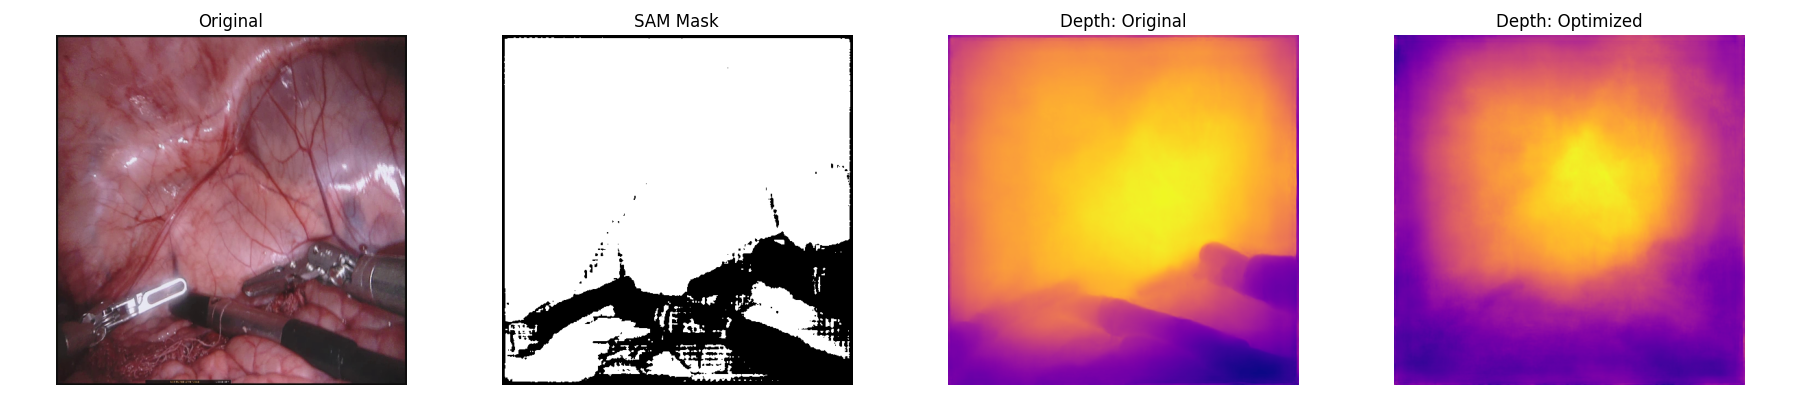

seq_1_frame255_compare.png


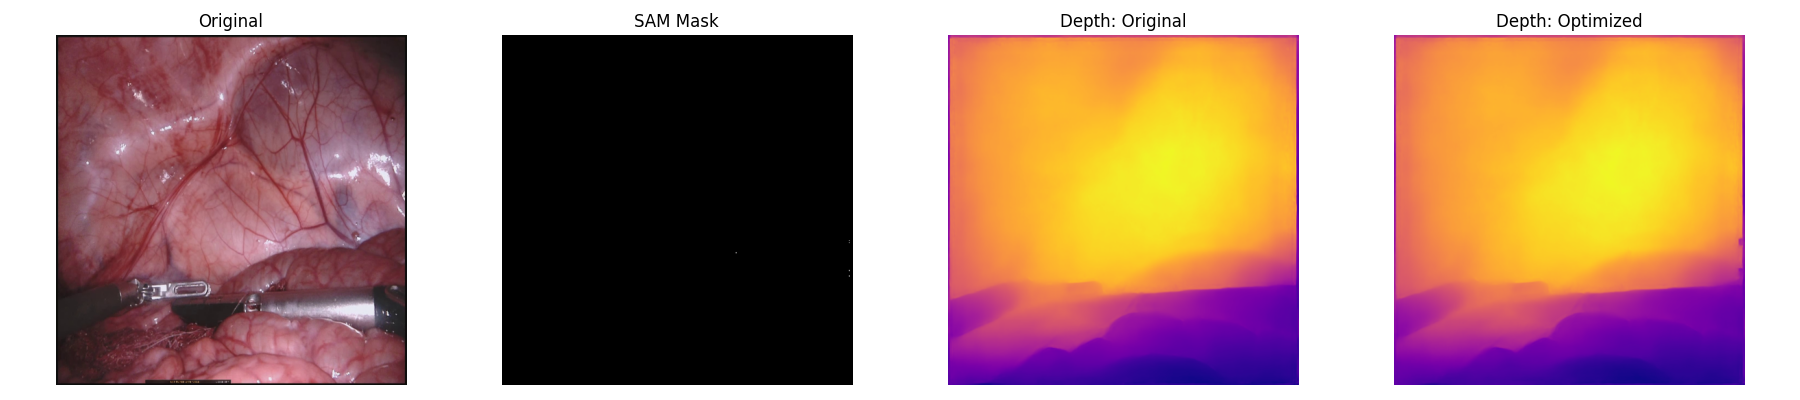

seq_1_frame293_compare.png


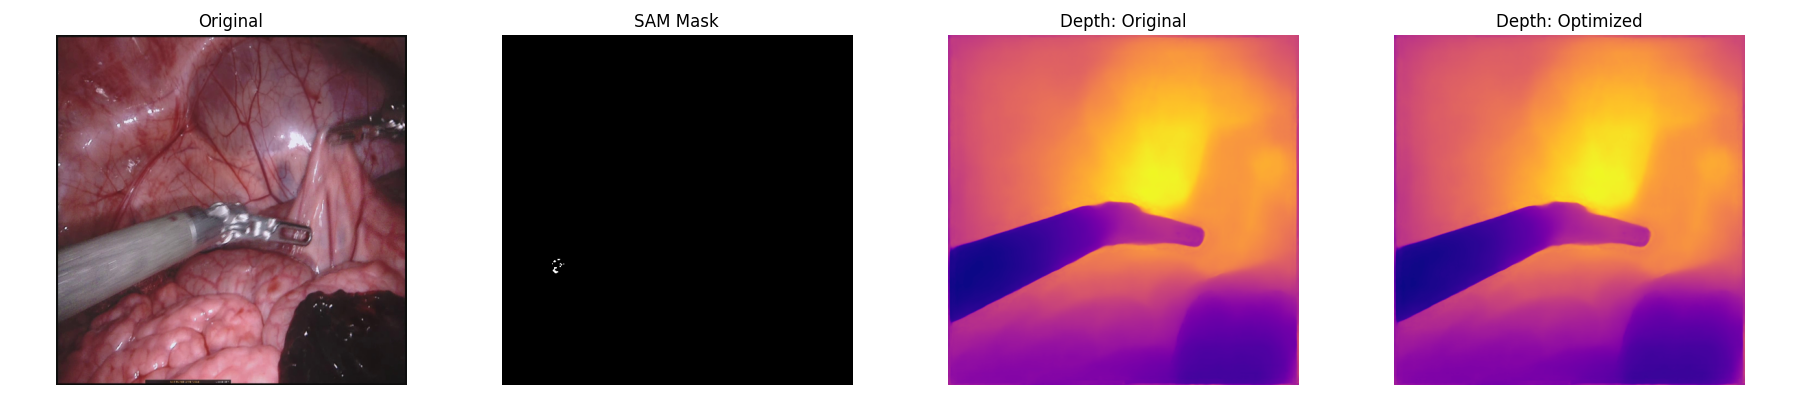

seq_1_frame298_compare.png


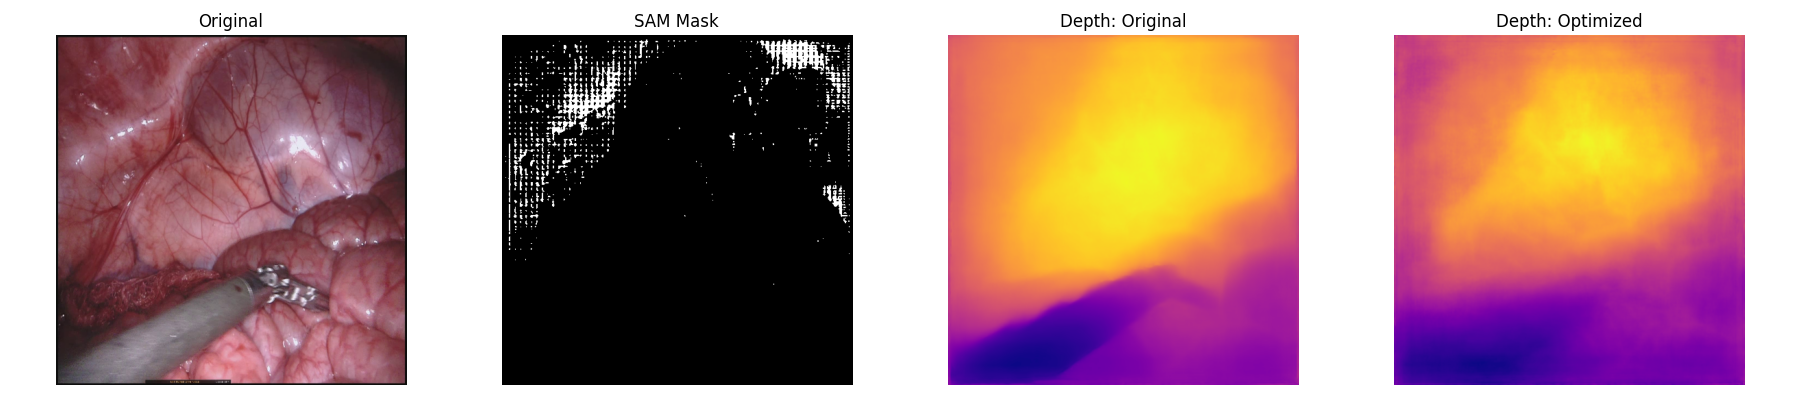

seq_2_frame234_compare.png


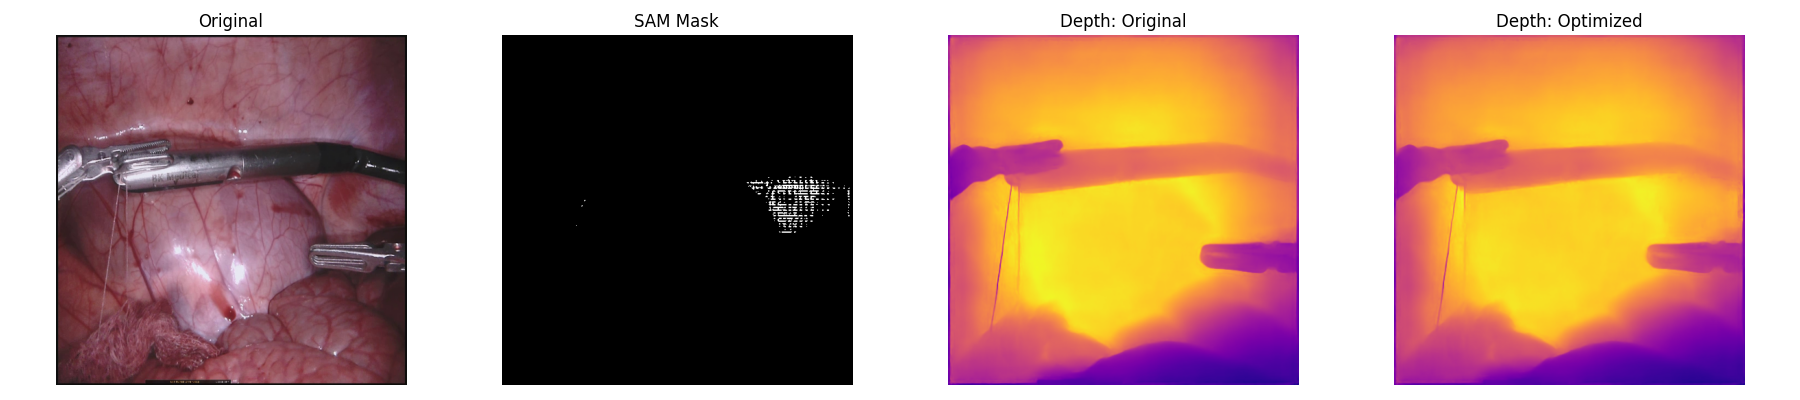

seq_2_frame254_compare.png


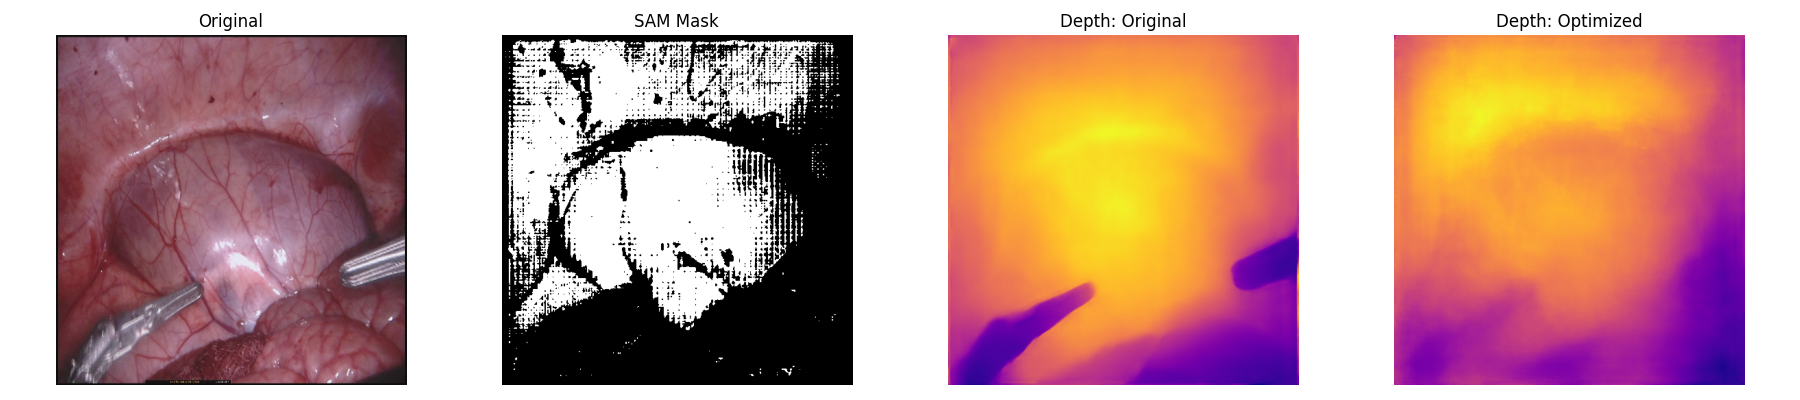

In [7]:
# 9. Batch generate depth maps and visualize comparisons (GPU/CPU safe)
output_dir = "/content/drive/MyDrive/Colab Notebooks/MR_Project/generated_files/depth_optimized"
os.makedirs(output_dir, exist_ok=True)

comparison_dir = os.path.join(output_dir, "visual_comparison")
os.makedirs(comparison_dir, exist_ok=True)

# 确定模型设备
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 更新 infer_depth_image，保证输入和模型同设备
def infer_depth_image(model, image: np.ndarray):
    """输入RGB图像，输出深度图（单位uint8）"""
    model.eval()
    # 转 tensor 并移动到模型所在设备
    device = next(model.parameters()).device
    img_tensor = torch.from_numpy(image.transpose(2,0,1)).unsqueeze(0).float().to(device)

    with torch.no_grad():
        # infer_image 接受 numpy，也可直接用 tensor，但要保证在同一设备
        # 如果 infer_image 不支持 tensor，可以先转回 numpy
        img_for_infer = image if device.type=='cpu' else image.copy()  # GPU infer 可能需要修改
        depth = model.infer_image(img_for_infer)  # 返回 HxW numpy
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    depth_uint8 = (depth_norm * 255).astype(np.uint8)
    return depth_uint8

stats = []
for fname in tqdm(sample_files, desc="Generating optimized depth"):
    img_path = os.path.join(test_image_dir, fname)
    mask_path = os.path.join(test_mask_dir, fname)

    # original depth
    img = np.array(Image.open(img_path).convert("RGB")).astype(np.float32)
    depth_uint8 = infer_depth_image(model, img)
    cv2.imwrite(os.path.join(output_dir, f"{fname}_original.png"), depth_uint8)
    stats.append({"file": fname, "mode": "original",
                  "mean_depth": depth_uint8.mean(), "std_depth": depth_uint8.std()})

    # optimized mask depth
    mod_img, depth_opt = generate_depth_with_mask_optimized(img_path, mask_path, depth_model=model)
    cv2.imwrite(os.path.join(output_dir, f"{fname}_optimized.png"), depth_opt)
    stats.append({"file": fname, "mode": "optimized",
                  "mean_depth": depth_opt.mean(), "std_depth": depth_opt.std()})

    # comparison
    img_rgb = np.array(Image.open(img_path).convert("RGB"))
    mask_arr = np.array(Image.open(mask_path).convert("L"))
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(img_rgb); axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(mask_arr, cmap="gray"); axes[1].set_title("SAM Mask"); axes[1].axis("off")
    axes[2].imshow(depth_uint8, cmap="plasma"); axes[2].set_title("Depth: Original"); axes[2].axis("off")
    axes[3].imshow(depth_opt, cmap="plasma"); axes[3].set_title("Depth: Optimized"); axes[3].axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(comparison_dir, fname.replace(".bmp", "_compare.png")))
    plt.close(fig)

# 保存统计数据
stats_df = pd.DataFrame(stats)
stats_csv = os.path.join(output_dir, "depth_statistics.csv")
stats_df.to_csv(stats_csv, index=False)
display(stats_df.head())

# 可视化部分图片
import glob
from IPython.display import Image as IPImage, display as ipy_display

comparison_images = sorted(glob.glob(os.path.join(comparison_dir, "*_compare.png")))
print(f"total {len(comparison_images)} comparisons.")
for path in comparison_images[:6]:
    print(os.path.basename(path))
    ipy_display(IPImage(filename=path))